In [1]:
from rdkit import Chem
import numpy as np
from collections import defaultdict
import sys
import pickle
import os
sys.path.append('../')
sys.path.append('../data_processing/')

from openbabel import pybel
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import torch
from tqdm import tqdm
import py3Dmol

In [2]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [3]:
from data_processing.ligand import Ligand
from data_processing.utils import sample_probability
from script_utils import load_qm9_data

In [64]:
generated_path = '/data/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/vp_bridge_egnn_QM9Dataset_2024-05-19_01_37_37.204170/reconstructed_mols'
# generated_path = '/data/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/vp_bridge_QM9Dataset_2024-05-19_01_34_10.875509/reconstructed_mols'

In [65]:
mols = []

for file in tqdm(os.listdir(generated_path)):
    m = Chem.MolFromMolFile(os.path.join(generated_path, file))
    mols.append(m)

  0%|                                                                                                                                                                    | 0/1675 [00:00<?, ?it/s][18:08:18] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:08:18] Explicit valence for atom # 12 N, 4, is greater than permitted
[18:08:18] Explicit valence for atom # 9 N, 4, is greater than permitted
[18:08:18] Explicit valence for atom # 4 N, 4, is greater than permitted
[18:08:18] Explicit valence for atom # 10 N, 4, is greater than permitted
[18:08:18] Explicit valence for atom # 12 N, 4, is greater than permitted
[18:08:18] Explicit valence for atom # 14 N, 4, is greater than permitted
[18:08:18] Explicit valence for atom # 16 N, 4, is greater than permitted
[18:08:18] Explicit valence for atom # 14 N, 4, is greater than permitted
[18:08:18] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:08:18] Explicit valence for atom # 11 N, 4, is greater than permi

In [66]:
len(os.listdir(generated_path)), len(mols)

(1675, 1675)

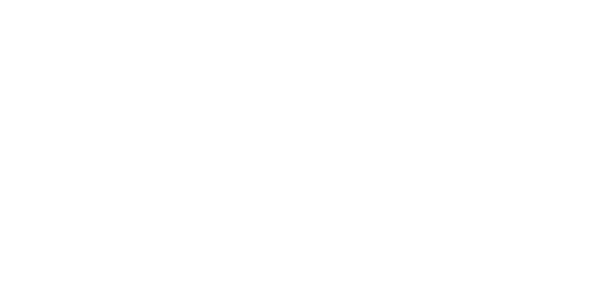

In [67]:
# m = mols[12]
smi = '[H]C([H])(C#N)[N@H+]1[C@]2([H])C([H])([H])[C@@]1(C([H])([H])[H])C2([H])[H]'
example = os.path.join(generated_path, smi+'.sdf')
m = Chem.MolFromMolFile(example)
m

In [68]:
v = py3Dmol.view()
v.addModel(open(example).read())
v.setStyle({'model':0},{'stick':{'colorscheme':'greenCarbon','radius':.125}})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.